In [ ]:
from google.colab.patches import cv2_imshow
import cv2 as cv
import cv2
import numpy as np
from keras.models import load_model
import tensorflow as tf 
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches
import imageio
from IPython.display import HTML, display
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#model_kicking = load_model('/content/drive/MyDrive/bothtoone.h5')
#model_punching = load_model('/content/drive/MyDrive/bothtoone.h5')

model1=load_model('/content/drive/MyDrive/BOWLINGitout.h5')

In [ ]:
i=0
if __name__ == '__main__':

    cap = cv.VideoCapture('/content/op.jpeg')
    # cap = cv.VideoCapture(0)
    frame_width = int(cap.get(3))
    frame_height = int(cap.get(4))
    size = (frame_width, frame_height)
    
    
    result = cv2.VideoWriter('/content/cricketoutput.avi', cv2.VideoWriter_fourcc(*'MJPG'),10, size)
    fps=0
    while cap.isOpened():
       hasFrame, frame = cap.read()
       if fps != 1:
          fps = fps+1
          continue
       else:
          black_img = np.zeros(frame.shape)
          out_frame = show_boxes(frame, black_img)
          
          result.write(out_frame)  
          print("frame",i)
          i=i+1
          fps=0
          #cv2.resizeWindow( 400, 300)
          #cv2_imshow(out_frame)



        # get frame from the video
        

        # Stop the program if reached end of video
        

AttributeError: ignored

check point --->>0


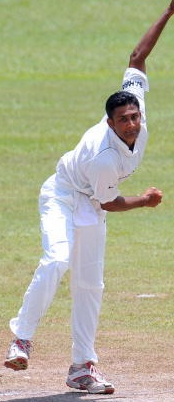

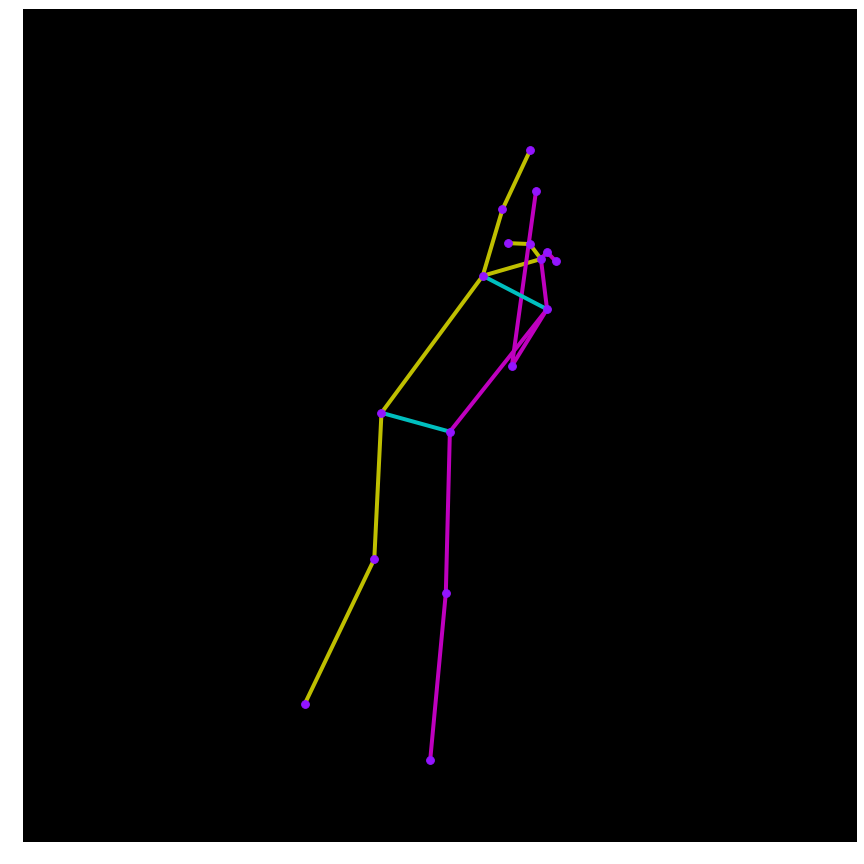

1/1 [==============================] - 0s 15ms/step
96.58 bowling


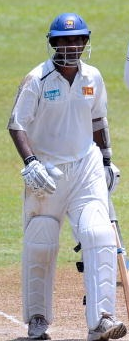

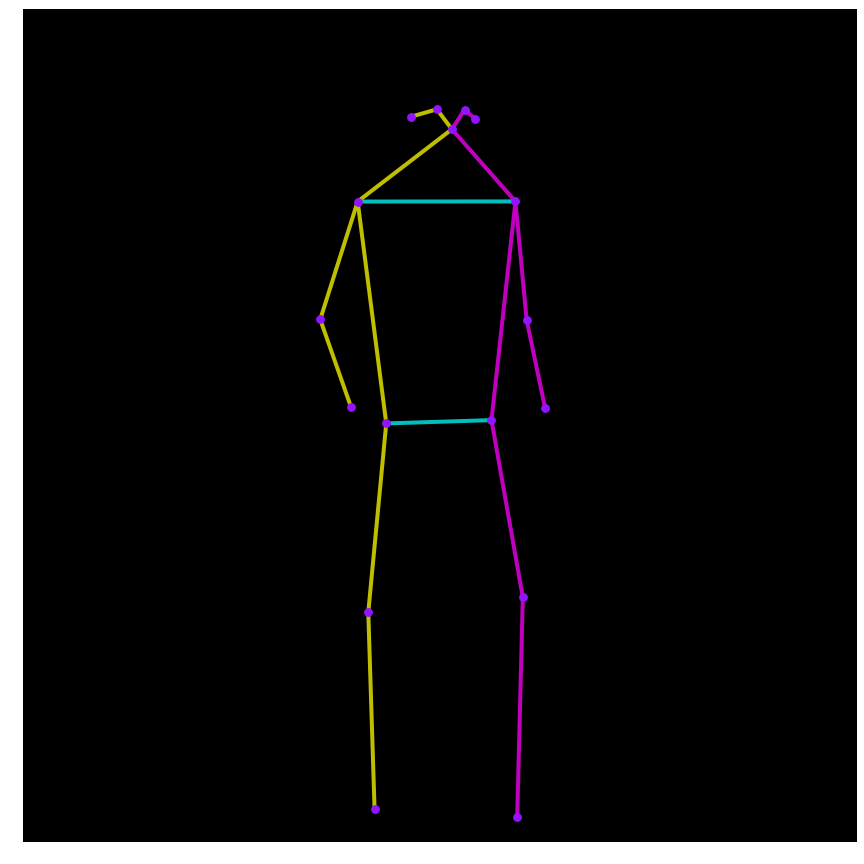

1/1 [==============================] - 0s 16ms/step
99.97 non-bowling


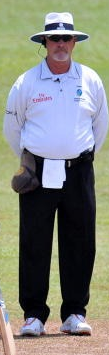

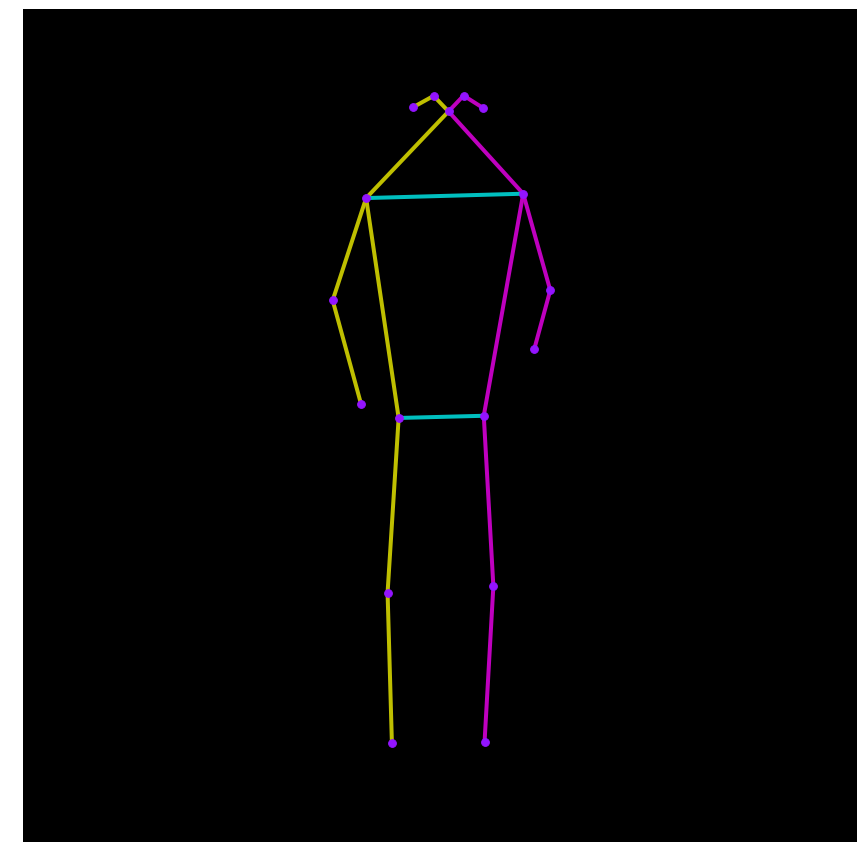

1/1 [==============================] - 0s 16ms/step
98.11 non-bowling


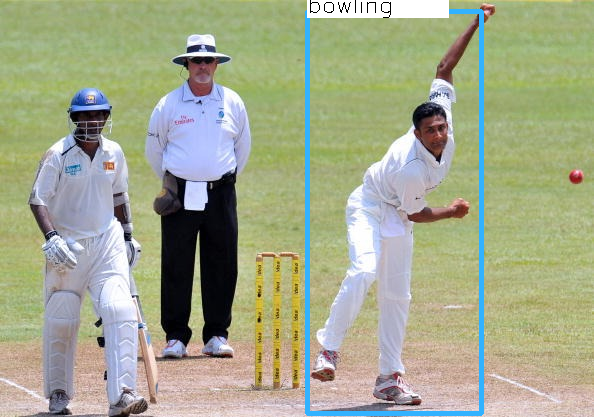

In [ ]:
frame = cv2.imread("/content/op.jpeg")
black_img = np.zeros(frame.shape)
out_frame = show_boxes(frame, black_img)
#print("frame",i)
cv2_imshow(out_frame)

In [ ]:


# Get the names of the output layers as the frd fuc need the name of the layer till which
# it has to run
def getOutputsNames(net):
    # Get the names of all the layers in the network
    layersNames = net.getLayerNames()
    # Get the names of the output layers, i.e. the layers with unconnected outputs
    return [layersNames[i - 1] for i in net.getUnconnectedOutLayers()]

# Draw the predicted bounding box


def drawPred(frame, classId, conf, left, top, right, bottom, classes, str_prediction):
    # Draw a bounding box.
    cv.rectangle(frame, (left, top), (right, bottom), (255, 178, 50), 3)

    label = '%.2f' % conf

    # Get the label for the class name and its confidence
    if classes:
        assert (classId < len(classes))
        label = '%s:%s' % (classes[classId], label)

    # Display the label at the top of the bounding box
    labelSize, baseLine = cv.getTextSize(
        label, cv.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    top = max(top, labelSize[1])
    cv.rectangle(frame, (left, top - round(1.5*labelSize[1])), (left + round(
        1.5*labelSize[0]), top + baseLine), (255, 255, 255), cv.FILLED)
    cv.putText(frame, str_prediction, (left, top),
               cv.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 0), 1)
    #cv2_imshow(frame)
    return frame

# Remove the bounding boxes with low confidence using non-maxima suppression


def show_boxes(frame, black_img):  # ,black_img
    confThreshold = 0.5  # Confidence threshold
    nmsThreshold = 0.4  # Non-maximum suppression threshold
    inpWidth = 416  # Width of network's input image
    inpHeight = 416  # Height of network's input image
    # Load names of classes
    classesFile = r"/content/drive/MyDrive/COCO.names"
    classes = None
    with open(classesFile, 'rt') as f:
        classes = f.read().rstrip('\n').split('\n')
    # Give the configuration and weight files for the model and load the network using them.
    modelConfiguration = r"/content/drive/MyDrive/yolov3.cfg"
    modelWeights = r"/content/drive/MyDrive/yolov3.weights"
    # * try to change backend and see the results
    net = cv.dnn.readNetFromDarknet(modelConfiguration, modelWeights)
    #net.setPreferableBackend(cv.dnn.DNN_BACKEND_OPENCV )
    # net.setPreferableTarget(cv.dnn.DNN_TARGET_OPENCL)
    net.setPreferableBackend(cv.dnn.DNN_BACKEND_OPENCV)
    net.setPreferableTarget(cv.dnn.DNN_TARGET_CPU)
    blob = cv.dnn.blobFromImage(frame, 1 / 255, (inpWidth, inpHeight), [0, 0, 0], 1, crop=False)
    # Sets the input to the network
    net.setInput(blob)
    # Runs the forward pass to get output of the output layers
    outs = net.forward(getOutputsNames(net))
    #print(outs)

    # Remove the bounding boxes with low confidence
    #frame_org_out = postprocess(frame, outs,confThreshold,classes,nmsThreshold,black_img)
    print("check point --->>0")
    frame_black_out = postprocess(frame, outs, confThreshold, classes, nmsThreshold, black_img)
    
    
    return frame_black_out
    #return frame_black_out,frame_org_out



In [ ]:
def postprocess(frame_org, outs, confThreshold, classes, nmsThreshold, black_img):
    frameHeight = frame_org.shape[0]
    frameWidth = frame_org.shape[1]

    # Scan through all the bounding boxes output from the network and keep only the
    # ones with high confidence scores. Assign the box's class label as the class with the highest score.
    classIds = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            classId = np.argmax(scores)
            confidence = scores[classId]
            # print(classes[classId])
            # print(str(confidence))
            if confidence > confThreshold and classes[classId] == "person":
                # if classes[classId] == "person":
                center_x = int(detection[0] * frameWidth)
                center_y = int(detection[1] * frameHeight)
                width = int(detection[2] * frameWidth)
                height = int(detection[3] * frameHeight)
                left = int(center_x - width / 2)
                top = int(center_y - height / 2)
                classIds.append(classId)
                confidences.append(float(confidence))
                boxes.append([left, top, width, height])

    # Perform non maximum suppression to eliminate redundant overlapping boxes with
    # lower confidences.
    indices = cv.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)
    for i in indices:
        i = i
        box = boxes[i]
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
        if_predict = True
        if if_predict:
          #print('RESULT')
          frame_ = frame_org[top:top + height, left:left + width]
          #print(frame_.shape)
          black_img = np.zeros(frame_.shape)
          input_image = tf.expand_dims(frame_, axis=0)
          input_image = tf.image.resize_with_pad(input_image, input_size, input_size)
          #print(input_image.shape)

        # Run model inference.
          keypoints_with_scores = movenet(input_image)

        # Visualize the predictions with image.
          display_image = tf.expand_dims(black_img, axis=0)
          display_image = tf.cast(tf.image.resize_with_pad(
          display_image, 180, 180), dtype=tf.int32)
          output_overlay = draw_prediction_on_image(
          np.squeeze(display_image.numpy(), axis=0), keypoints_with_scores)
          img_height = 180
          img_width = 180
          
          cv2_imshow(frame_)
          cv2_imshow(output_overlay)
          cv2.imwrite('/content/output/img.png',output_overlay)
          img = tf.keras.utils.load_img('/content/output/img.png', target_size=(img_height, img_width))
          img_array = tf.keras.utils.img_to_array(img)
          img_array = tf.expand_dims(img_array, 0) # Create a batch

          predictions = model1.predict(img_array)
          score = tf.nn.softmax(predictions[0])
          class_names=['bowling', 'non-bowling']
          point = round(np.max(score)*100,2)
          
          str_prediction = class_names[np.argmax(score)]

          print(point, str_prediction)
          if(point>=85 and str_prediction =='bowling'):
            frame_org = drawPred(frame_org,classIds[i], confidences[i], left , top, left + width, top + height,classes,str_prediction)

          #print("This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score)))
        
    return frame_org
    # return black_img , frame_org

## PART II

In [ ]:
model_name = "movenet_lightning" #@param ["movenet_lightning", "movenet_thunder", "movenet_lightning_f16.tflite", "movenet_thunder_f16.tflite", "movenet_lightning_int8.tflite", "movenet_thunder_int8.tflite"]

if "tflite" in model_name:
  if "movenet_lightning_f16" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/float16/4?lite-format=tflite
    input_size = 192
  elif "movenet_thunder_f16" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite
    input_size = 256
  elif "movenet_lightning_int8" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/int8/4?lite-format=tflite
    input_size = 192
  elif "movenet_thunder_int8" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/int8/4?lite-format=tflite
    input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_path="model.tflite")
  interpreter.allocate_tensors()

  def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    # TF Lite format expects tensor type of uint8.
    input_image = tf.cast(input_image, dtype=tf.uint8)
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'], input_image.numpy())
    # Invoke inference.
    interpreter.invoke()
    # Get the model prediction.
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
    return keypoints_with_scores

else:
  if "movenet_lightning" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
    input_size = 192
  elif "movenet_thunder" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")
    input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)

  def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    model = module.signatures['serving_default']

    # SavedModel format expects tensor type of int32.
    input_image = tf.cast(input_image, dtype=tf.int32)
    # Run model inference.
    outputs = model(input_image)
    # Output is a [1, 1, 17, 3] tensor.
    keypoints_with_scores = outputs['output_0'].numpy()
    return keypoints_with_scores


In [ ]:
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

# Maps bones to a matplotlib color name.
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

def _keypoints_and_edges_for_display(keypoints_with_scores,
                                     height,
                                     width,
                                     keypoint_threshold=0.11):
  """Returns high confidence keypoints and edges for visualization.

  Args:
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    height: height of the image in pixels.
    width: width of the image in pixels.
    keypoint_threshold: minimum confidence score for a keypoint to be
      visualized.

  Returns:
    A (keypoints_xy, edges_xy, edge_colors) containing:
      * the coordinates of all keypoints of all detected entities;
      * the coordinates of all skeleton edges of all detected entities;
      * the colors in which the edges should be plotted.
  """
  keypoints_all = []
  keypoint_edges_all = []
  edge_colors = []
  num_instances, _, _, _ = keypoints_with_scores.shape
  for idx in range(num_instances):
    kpts_x = keypoints_with_scores[0, idx, :, 1]
    kpts_y = keypoints_with_scores[0, idx, :, 0]
    kpts_scores = keypoints_with_scores[0, idx, :, 2]
    kpts_absolute_xy = np.stack(
        [width * np.array(kpts_x), height * np.array(kpts_y)], axis=-1)
    kpts_above_thresh_absolute = kpts_absolute_xy[
        kpts_scores > keypoint_threshold, :]
    keypoints_all.append(kpts_above_thresh_absolute)

    for edge_pair, color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
      if (kpts_scores[edge_pair[0]] > keypoint_threshold and
          kpts_scores[edge_pair[1]] > keypoint_threshold):
        x_start = kpts_absolute_xy[edge_pair[0], 0]
        y_start = kpts_absolute_xy[edge_pair[0], 1]
        x_end = kpts_absolute_xy[edge_pair[1], 0]
        y_end = kpts_absolute_xy[edge_pair[1], 1]
        line_seg = np.array([[x_start, y_start], [x_end, y_end]])
        keypoint_edges_all.append(line_seg)
        edge_colors.append(color)
  if keypoints_all:
    keypoints_xy = np.concatenate(keypoints_all, axis=0)
  else:
    keypoints_xy = np.zeros((0, 17, 2))

  if keypoint_edges_all:
    edges_xy = np.stack(keypoint_edges_all, axis=0)
  else:
    edges_xy = np.zeros((0, 2, 2))
  return keypoints_xy, edges_xy, edge_colors


def draw_prediction_on_image(
    image, keypoints_with_scores, crop_region=None, close_figure=False,
    output_image_height=None):
  """Draws the keypoint predictions on image.

  Args:
    image: A numpy array with shape [height, width, channel] representing the
      pixel values of the input image.
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    crop_region: A dictionary that defines the coordinates of the bounding box
      of the crop region in normalized coordinates (see the init_crop_region
      function below for more detail). If provided, this function will also
      draw the bounding box on the image.
    output_image_height: An integer indicating the height of the output image.
      Note that the image aspect ratio will be the same as the input image.

  Returns:
    A numpy array with shape [out_height, out_width, channel] representing the
    image overlaid with keypoint predictions.
  """
  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  # To remove the huge white borders
  fig.tight_layout(pad=0)
  ax.margins(0)
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  plt.axis('off')

  im = ax.imshow(image)
  line_segments = LineCollection([], linewidths=(4), linestyle='solid')
  ax.add_collection(line_segments)
  # Turn off tick labels
  scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)

  (keypoint_locs, keypoint_edges,
   edge_colors) = _keypoints_and_edges_for_display(
       keypoints_with_scores, height, width)

  line_segments.set_segments(keypoint_edges)
  line_segments.set_color(edge_colors)
  if keypoint_edges.shape[0]:
    line_segments.set_segments(keypoint_edges)
    line_segments.set_color(edge_colors)
  if keypoint_locs.shape[0]:
    scat.set_offsets(keypoint_locs)

  if crop_region is not None:
    xmin = max(crop_region['x_min'] * width, 0.0)
    ymin = max(crop_region['y_min'] * height, 0.0)
    rec_width = min(crop_region['x_max'], 0.99) * width - xmin
    rec_height = min(crop_region['y_max'], 0.99) * height - ymin
    rect = patches.Rectangle(
        (xmin,ymin),rec_width,rec_height,
        linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect)

  fig.canvas.draw()
  image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  image_from_plot = image_from_plot.reshape(
      fig.canvas.get_width_height()[::-1] + (3,))
  plt.close(fig)
  if output_image_height is not None:
    output_image_width = int(output_image_height / height * width)
    image_from_plot = cv2.resize(
        image_from_plot, dsize=(output_image_width, output_image_height),
         interpolation=cv2.INTER_CUBIC)
  return image_from_plot

def to_gif(images, fps):
  """Converts image sequence (4D numpy array) to gif."""
  imageio.mimsave('./animation.gif', images, fps=fps)
  return embed.embed_file('./animation.gif')

def progress(value, max=100):
  return HTML("""
      <progress
          value='{value}'
          max='{max}',
          style='width: 100%'
      >
          {value}
      </progress>
  """.format(value=value, max=max))

## PART3 --verification

In [ ]:

img_height = 180
img_width = 180
class_names=['Kicking', 'Punching']
model1=load_model('/content/drive/MyDrive/kick_punch_2.h5')
img = tf.keras.utils.load_img(
    '/content/drive/MyDrive/Violence_Detection/cap_100.png', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model1.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)